# Azure Custom Vision ONNX

https://learn.microsoft.com/en-us/azure/ai-services/custom-vision-service/overview

https://onnx.ai/

In [1]:
import datetime
import gradio as gr
import numpy as np
import onnx
import onnxruntime
import pathlib
import sys
import time

from pathlib import Path
from PIL import Image

In [2]:
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 08-Apr-2025 15:44:41


## Settings

In [4]:
labels_file = "labels.txt"

In [5]:
with open(labels_file, 'r') as file:
    content = file.read()

print(content)

damage
no_damage


In [6]:
onnx_file = "model.onnx"

In [7]:
model_filepath = pathlib.Path(onnx_file)

In [8]:
print("ONNX model:", model_filepath)
print("ONNX runtime version:", onnxruntime.__version__)

ONNX model: model.onnx
ONNX runtime version: 1.19.2


In [9]:
file_path = Path(onnx_file)
file_size_bytes = file_path.stat().st_size
file_size_mb = file_size_bytes / (1024 * 1024)
print(f'The size of {onnx_file} = {file_size_mb:.2f} MB')

The size of model.onnx = 42.57 MB


## Functions

In [10]:
class Model:
    def __init__(self, model_filepath):
        """
        Initializes the model for image classification using an ONNX model.

        This constructor sets up the ONNX runtime session, extracts the input
        and output details of the model, and checks for specific metadata 
        properties related to image preprocessing.

        Args:
            model_filepath (str): The file path to the ONNX model.

        Attributes:
            session (onnxruntime.InferenceSession): The ONNX runtime session 
            for the model.
            input_shape (tuple): The shape of the model's input tensor.
            input_name (str): The name of the model's input tensor.
            input_type (type): The data type of the model's input tensor.
            output_names (list): A list of the model's output tensor names.
            is_bgr (bool): Indicates if the model expects BGR formatted images.
            is_range255 (bool): Indicates if the model expects pixel values in
            the range [0, 255].
        """
        self.session = onnxruntime.InferenceSession(str(model_filepath))
        assert len(self.session.get_inputs()) == 1
        self.input_shape = self.session.get_inputs()[0].shape[2:]
        self.input_name = self.session.get_inputs()[0].name
        self.input_type = {
            'tensor(float)': np.float32,
            'tensor(float16)': np.float16
        }[self.session.get_inputs()[0].type]
        self.output_names = [o.name for o in self.session.get_outputs()]
        self.is_bgr = False
        self.is_range255 = False

        onnx_model = onnx.load(model_filepath)
        for metadata in onnx_model.metadata_props:
            if metadata.key == 'Image.BitmapPixelFormat' and metadata.value == 'Bgr8':
                self.is_bgr = True
            elif metadata.key == 'Image.NominalPixelRange' and metadata.value == 'NominalRange_0_255':
                self.is_range255 = True

    def predict(self, image_filepath):
        """
        Predicts the classes of a given image using an ONNX model.

        This method loads an image from the specified file path, resizes it
        according to the model's input shape, and performs the necessary 
        preprocessing before passing the image through the ONNX model to 
        obtain predictions.

        Args:
            image_filepath (str): The file path of the image to classify.

        Returns:
            dict: A dictionary containing the output names as keys and the 
            prediction results as values.
        """
        image = Image.open(image_filepath).resize(self.input_shape)
        input_array = np.array(image, dtype=np.float32)[np.newaxis, :, :, :]
        input_array = input_array.transpose((0, 3, 1, 2))  # => (N, C, H, W)

        if self.is_bgr:
            input_array = input_array[:, (2, 1, 0), :, :]
        if not self.is_range255:
            # => Pixel values should be in range [0, 1]
            input_array = input_array / 255

        outputs = self.session.run(
            self.output_names,
            {self.input_name: input_array.astype(self.input_type)})
        return {name: outputs[i] for i, name in enumerate(self.output_names)}


def print_outputs(outputs):
    """
    Prints the given outputs.
    This function takes an input and prints it to the console.
    """
    print(outputs)

In [11]:
def get_onnx_image_classification(image_file):
    """
    Performs image classification using an Azure Custom Vision ONNX model 
    and returns the prediction and score.

    Args:
        image_file: Image file to be classified.

    Returns:
        tuple: Contains the prediction (str) and the score (float).
    """
    # Get Labels
    with open(labels_file, 'r') as file:
        label1 = file.readline().strip()
        label2 = file.readline().strip()
        labels = [label1, label2]

    # Load model
    model = Model(model_filepath)

    # Get results
    predictions = model.predict(image_file)
    score = np.max(predictions["model_output"])
    max_index = np.argmax(predictions["model_output"])
    prediction = labels[1] if max_index == 1 else labels[0]

    # Print results
    color_code = "\033[1;31;91m" if prediction == label1 else "\033[1;31;32m"
    print(color_code)
    print(f"Prediction: {prediction} with score = {score}")
    print("\033[0m")
    return labels, predictions

## Tests

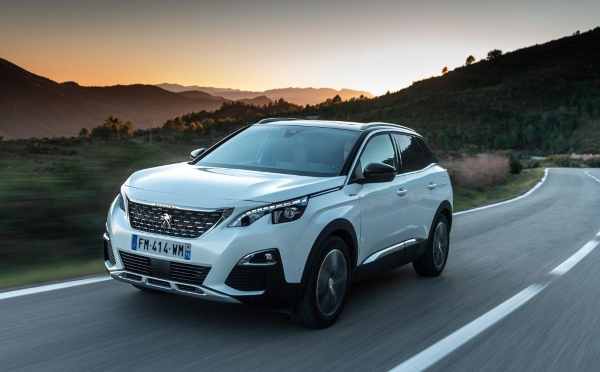

In [12]:
image_file = pathlib.Path("images/car1.jpg")

img = Image.open(image_file)
img

In [13]:
start = time.time()
results = get_onnx_image_classification(image_file)
print(f"Done in {time.time() - start:5f} seconds")


Prediction: no_damage with score = 0.9977623224258423

Done in 0.400348 seconds


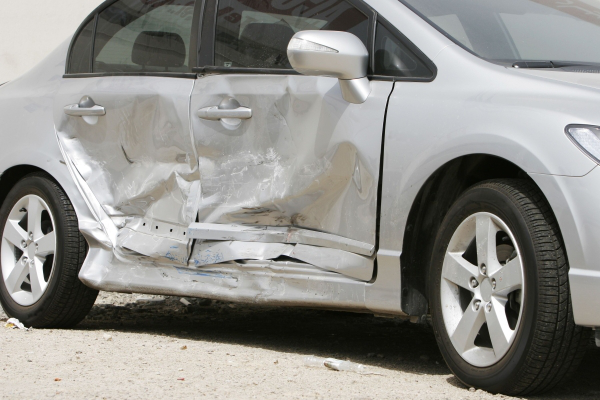

In [14]:
image_file = pathlib.Path("images/car2.jpg")

img = Image.open(image_file)
img

In [15]:
start = time.time()
get_onnx_image_classification(image_file)
print(f"Done in {time.time() - start:5f} seconds")


Prediction: damage with score = 0.8662431836128235

Done in 0.263030 seconds


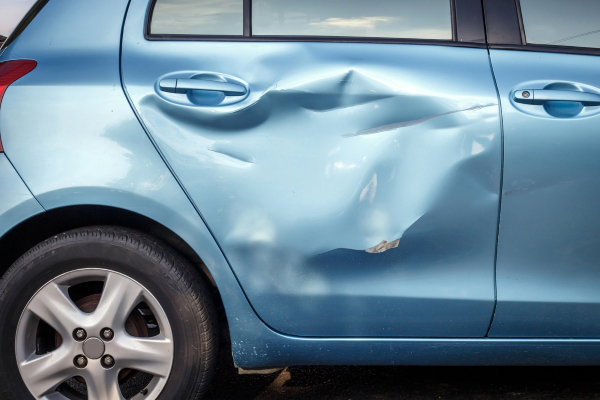

In [16]:
image_file = pathlib.Path("images/car3.jpg")

img = Image.open(image_file)
img

In [17]:
start = time.time()
get_onnx_image_classification(image_file)
print(f"Done in {time.time() - start:5f} seconds")


Prediction: damage with score = 0.7733387351036072

Done in 0.271988 seconds


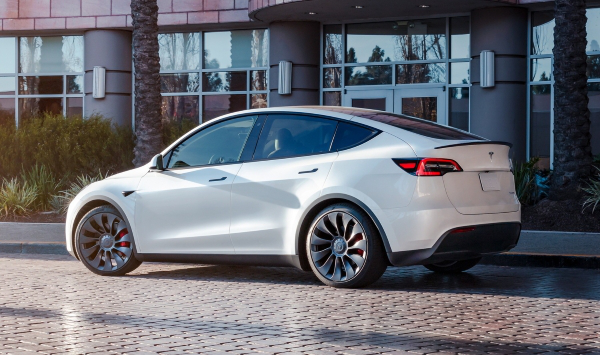

In [18]:
image_file = pathlib.Path("images/car4.jpg")

img = Image.open(image_file)
img

In [19]:
start = time.time()
get_onnx_image_classification(image_file)
print(f"Done in {time.time() - start:5f} seconds")


Prediction: no_damage with score = 0.9246039390563965

Done in 0.267076 seconds


## Webapp

In [20]:
def get_onnx_image_classification_fn(image):
    """
    Classifies an image using an Azure Custom Vision ONNX model and returns 
    the results as a dictionary for a Gradio Webapp.

    Args:
        image: The image to classify.

    Returns:
        dict: A dictionary containing the labels and classification scores.
    """
    labels, predictions = get_onnx_image_classification(image)
    score_values = predictions['model_output'].tolist()[0]
    results = {labels[i]: float(score_values[i]) for i in range(len(labels))}

    return results

In [21]:
title = "Image classification ONNX deployed model using Azure Custom Vision"

samples = [
    "images/car1.jpg",
    "images/car2.jpg",
    "images/car3.jpg",
    "images/car4.jpg",
    "images/car5.jpg",
    "images/car6.jpg",
]

webapp = gr.Interface(
    fn=get_onnx_image_classification_fn,
    inputs=gr.Image(type="filepath", label="Upload an image to classify"),
    outputs=gr.Label(num_top_classes=2, label="Classification results"),
    title=title,
    examples=samples,
    theme="Zarkel/IBM_Carbon_Theme",
)

webapp.launch(share=True)

theme_schema%400.0.5.json:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

C:\Users\seretkow\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\seretkow\.cache\huggingface\hub\spaces--Zarkel--IBM_Carbon_Theme. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
